<center>
    <h1>Notebook untuk Pipeline RAG</h1>
</center>

> Dokumen yang digunakan dalam pengerjakan RAG ini diperoleh dari [WikiVoyage](https://en.wikivoyage.org/wiki/Main_Page)

### Install Library

In [1]:
!pip install torch transformers==4.45.2 accelerate bitsandbytes==0.43.2 marker-pdf==0.2.17 langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41

### Import Library

In [1]:
from langchain_text_splitters import (
    MarkdownHeaderTextSplitter,
    RecursiveCharacterTextSplitter,
)
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import SystemMessage
from marker.convert import convert_single_pdf
from marker.logger import configure_logging
from marker.models import load_all_models
from tqdm import tqdm
from typing import Optional, List, Tuple
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from transformers import AutoTokenizer, Pipeline, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel
from huggingface_hub import login
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
import hashlib
import pickle
import pacmap
import numpy as np
import plotly.express as px

## Pre-Process Documents

### Function Declaration

In [2]:
def ParserFileName(filename):
    cleaned_filename = filename.replace(" ", "").replace(".", "")
    if filename.endswith(".pdf"):
        cleaned_filename = cleaned_filename[:-3] + ".pdf"
    return cleaned_filename

In [3]:
def PDFtoMD(fname, reference_folder, model_lst, md_out_path=None):
    pdf_filename = os.path.join(reference_folder, fname)
    md_filename = os.path.splitext(fname)[0] + ".md"

    full_text, _, _ = convert_single_pdf(pdf_filename, model_lst, batch_multiplier=1)

    if md_out_path:
        output_path = os.path.join(md_out_path, md_filename)
        with open(output_path, "w") as f:
            f.write(full_text)
    else:
        return full_text

In [4]:
def ProcessFiles(
    file_key, text_splitter, markdown_splitter, model_lst, reference_folder="./data/"
):
    parsed_file_name = ParserFileName(file_key)
    temp_file_path = os.path.join(reference_folder, parsed_file_name)

    markdown_content = PDFtoMD(parsed_file_name, reference_folder, model_lst)

    header_splits = markdown_splitter.split_text(markdown_content)

    documents = []
    for header_split in header_splits:
        text_splits = text_splitter.split_text(header_split.page_content)

        for part_index, text_split in enumerate(text_splits):
            doc_identifier = f"{file_key}_part_{part_index}"
            hash_hex = hashlib.md5(doc_identifier.encode()).hexdigest()[:10]

            metadata = {
                "document_id": hash_hex,
                "pdf_name": file_key,
                "pdf_part": part_index,
                **header_split.metadata,
            }

            documents.append({"metadata": metadata, "content": text_split})

    return documents

In [5]:
def PDFCounter(directory_path):
    if not os.path.isdir(directory_path):
        print(f"Error: The directory '{directory_path}' does not exist.")
        return []

    return [f for f in os.listdir(directory_path) if f.lower().endswith(".pdf")]


directory = "./data/"
filenames = PDFCounter(directory)
print(f"Number of PDF file: {len(filenames)}")

Number of PDF file: 10


In [6]:
configure_logging()
model_lst = load_all_models()

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/154M [00:00<?, ?B/s]

Loaded detection model vikp/surya_det3 on device cuda with dtype torch.float16


preprocessor_config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/154M [00:00<?, ?B/s]

Loaded detection model vikp/surya_layout3 on device cuda with dtype torch.float16


preprocessor_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/550M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Loaded reading order model vikp/surya_order on device cuda with dtype torch.float16


preprocessor_config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/8.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/941M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

Loaded recognition model vikp/surya_rec2 on device cuda with dtype torch.float16


preprocessor_config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/625M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Loaded texify model to cuda with torch.float16 dtype


preprocessor_config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

In [7]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
chunk_size = 500
chunk_overlap = 100
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

### Load Documents

In [8]:
documents = []

for filename in tqdm(filenames):

    print("\nFile: {} \n".format(filename))

    splitted_doc = ProcessFiles(
        filename,
        text_splitter,
        markdown_splitter,
        model_lst,
        reference_folder="./data/",
    )

    documents.append(splitted_doc)

  0%|          | 0/10 [00:00<?, ?it/s]


File: Cambodia.pdf 




Detecting bboxes: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]

Detecting bboxes: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]

 10%|█         | 1/10 [01:36<14:26, 96.24s/it]


File: Myanmar.pdf 




Detecting bboxes: 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

Detecting bboxes: 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]

 20%|██        | 2/10 [03:06<12:19, 92.44s/it]


File: Vietnam.pdf 




Detecting bboxes: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]

Detecting bboxes: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

 30%|███       | 3/10 [05:04<12:09, 104.26s/it]


File: Singapore.pdf 




Detecting bboxes: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]

Detecting bboxes: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]

 40%|████      | 4/10 [07:51<12:53, 128.93s/it]


File: Brunei.pdf 




Detecting bboxes: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

Detecting bboxes: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

 50%|█████     | 5/10 [08:45<08:30, 102.08s/it]


File: Philippines.pdf 




Detecting bboxes: 100%|██████████| 19/19 [00:14<00:00,  1.35it/s]

Detecting bboxes: 100%|██████████| 13/13 [00:17<00:00,  1.37s/it]

 60%|██████    | 6/10 [11:24<08:06, 121.51s/it]


File: Laos.pdf 




Detecting bboxes: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

Detecting bboxes: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

 70%|███████   | 7/10 [12:49<05:28, 109.48s/it]


File: Malaysia.pdf 




Detecting bboxes: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

Detecting bboxes: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]

 80%|████████  | 8/10 [14:24<03:29, 104.91s/it]


File: Thailand.pdf 




Detecting bboxes: 100%|██████████| 17/17 [00:12<00:00,  1.34it/s]

Detecting bboxes: 100%|██████████| 11/11 [00:15<00:00,  1.40s/it]

 90%|█████████ | 9/10 [16:47<01:56, 116.72s/it]


File: Indonesia.pdf 




Detecting bboxes: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]

Detecting bboxes: 100%|██████████| 12/12 [00:15<00:00,  1.32s/it]

100%|██████████| 10/10 [19:16<00:00, 115.66s/it]


In [9]:
with open("./data/pickle/docs_processed.pickle", "wb") as f:
    pickle.dump(documents, f)

In [10]:
flattened_list = [item for sublist in documents for item in sublist]

In [11]:
flattened_list[5]

{'metadata': {'document_id': '85742cf4d9',
  'pdf_name': 'Cambodia.pdf',
  'pdf_part': 4,
  'Header 2': 'Regions'},
 'content': 'Park, and the pepper and durian capital of Cambodia Koh Kong - small border crossing town near the Thai border Kampong Thom - access to less well known (and less crowded) ancient temples and other sites Kratie - relaxed river town in the northeast on the Mekong, and an excellent place to get a close look at endangered river dolphins Siem Reap - access point for Angkor Wat and various other attractions in the north Sihanoukville - seaside town in the south, also known as Kompong Som 6 7 8 9'}

In [12]:
with open("./data/pickle/docs_processed.pickle", "wb") as f:
    pickle.dump(flattened_list, f)

In [13]:
with open("./data/pickle/docs_processed.pickle", "rb") as f:
    documents = pickle.load(f)

In [14]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["content"], metadata=doc["metadata"])
    for doc in tqdm(documents)
]

100%|██████████| 4262/4262 [00:00<00:00, 232771.12it/s]


### Process Documents

In [15]:
# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

100%|██████████| 4262/4262 [00:01<00:00, 3092.28it/s]


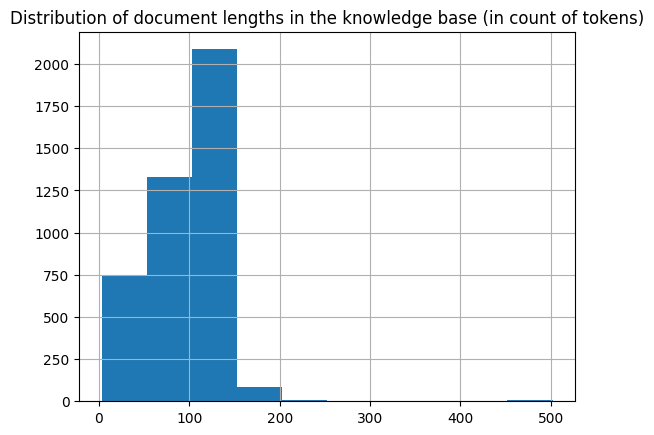

In [16]:
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small", cache_dir="./cache")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

## Building Vector Database

### Load Embedding Model

In [17]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    cache_folder="./cache",
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-17-0a81d9f19d05>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Tried Query

In [18]:
# Embed a user query in the same space
user_query = "What can i see in Indonesia?"
query_vector = embedding_model.embed_query(user_query)

In [19]:
embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

### Query Visualization

In [20]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["pdf_name"].split("/")[0],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [21]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='What can i see in Indonesia?'...

==================================Top document==================================
The nation of Indonesia is almost unimaginably vast: More than 18,000 islands providing 108,000 km of beaches. The distance between Aceh in the west and Papua in the east is 4,702 km (2,500 mi), comparable to the distance between New York City and San Francisco. Lying on the western rim of the Ring of Fire, Indonesia has more than 400 volcanoes, of which 129 are considered active, as well as many undersea volcanoes. The island of New Guinea (on which the Indonesian province of Papua is located)
==================================Metadata==================================
{'document_id': '0f5f363906', 'pdf_name': 'Indonesia.pdf', 'pdf_part': 0, 'Header 2': 'Regions', 'start_index': 0}


## Reader LLM

### Reader Model

In [22]:
from transformers import pipeline
READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [23]:
READER_LLM("How many countries in South East Asia? Answer:")

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


[{'generated_text': " 11\nGroupLayout:\nThe Southeast Asian region, also known as Southeastern Asia or Southem Asia, is a subregion of Asia, consisting of the following twelve states (listed here in alphabetical order): Brunei, Cambodia, East Timor (Timor-Leste), Indonesia, Laos, Malaysia, Myanmar, Philippines, Singapore, Thailand, and Vietnam. The region's largest city is Shanghai, while its most populous city is Jakarta.\nThe region's largest country by area is Indonesia; the most populous nation is Indonesia as well. The region's most populous city is Jakarta, Indonesia. The region's largest religion is Islam, with Christianity being a close second.\nSoutheast Asia is home to some of the world's fastest growing economies, such as Vietnam and the Philippines, as well as newly industrialized economies like Singapore, Malaysia, and Thailand. The region is rich in natural resources, although environmental concerns are becoming increasingly prominent.\nThe region has been characterized b

### Prompt

In [24]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [25]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="What can i see in Indonesia?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Indonesia offers a wide variety of attractions for visitors. Some of the most popular destinations include:

1. Bali - Known as the "Island of the Gods," Bali is famous for its stunning beaches, lush rice terraces, and vibrant culture.

2. Borobudur - This ancient Buddhist temple in Central Java is the largest in the world and a UNESCO World Heritage Site.

3. Komodo National Park - Home to the famous Komodo dragons, this park also features crystal-clear waters and diverse marine life.

4. Tanah Lot Temple - Located on a rock formation off the coast of Bali, this iconic temple is surrounded by crashing waves and offers breathtaking views.

5. Raja Ampat - This remote archipelago in West Papua boasts some of the world's most pristine coral reefs and abundant marine life.

6. Ubud - A charming town in Bali known for its art and craft scene, traditional Balinese dance performances, and lush green rice paddies.

7. Temples of Prambanan - These Hindu temples near Yogyakarta date back to the

### Reranking

In [26]:
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Ansemble

In [27]:
def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [28]:
question = "What can i see in Indonesia?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.07it/s]

=> Generating answer...


In [29]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
In Indonesia, you can see a variety of attractions such as stunning natural landscapes like the world's largest volcanic lake in Lake Toba or the vast Kerinci Seblat National Park with its tigers, elephants, and rafflesia flowers. There are also ancient cultural sites like Borobudur, the world's largest Buddhist monument, and Prambanan, a notable Hindu monument. For adventure seekers, Indonesia offers some of the best scuba diving spots in the world, including Bunaken, Wakatobi, Alor Archipelago, and Raja Ampat. Additionally, Bali, although well-known, is just one of Indonesia's 18,000 inhabited islands, each offering unique experiences. Overall, Indonesia's diverse culture, enchanting nature, and friendly people make it a truly exotic destination. (Documents 0, 1, 2, 3, and 4)
==================================Source docs==================================
Document 0----------------------------------------------

## Evaluation

In [30]:
def prepare_rag_evaluation_dataset(input_csv_path, output_csv_path):
    # Load the input CSV
    df = pd.read_csv(input_csv_path)

    # Initialize an empty list to store RAG inferences
    inferences = []

    # Iterate through each row and perform RAG
    for _, row in df.iterrows():
        try:
            # Perform RAG call
            # Note: You'll need to replace this with your actual RAG implementation
            question = row['question']
            answer, relevant_docs = answer_with_rag(
                question,
                READER_LLM,
                KNOWLEDGE_VECTOR_DATABASE,
                reranker=RERANKER
            )

            # Store the inference
            inferences.append(answer)

        except Exception as e:
            print(f"Error processing row: {row['id']}")
            print(f"Error details: {str(e)}")
            inferences.append(None)

    # Add the inference column to the DataFrame
    df['inference'] = inferences

    # Save the updated dataset
    df.to_csv(output_csv_path, index=False)

    return df

In [31]:
input_path = './data/evaluation/groundtruth.csv'
output_path = './data/evaluation/rag_evaluation_dataset.csv'

result_df = prepare_rag_evaluation_dataset(input_path, output_path)

print("Dataset prepared successfully!")
print(f"Total rows: {len(result_df)}")
print("\nSample of the dataset:")
print(result_df.head())

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.83it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 15.36it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 11.73it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.70it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.91it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 15.23it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 12.73it/s]
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


=> Generating answer...
=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.38it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.83it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.39it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.84it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.58it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 12.12it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.85it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.16it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 12.86it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.74it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.89it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.22it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 12.56it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.47it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.06it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.65it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.33it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.98it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 12.48it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 12.26it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 11.82it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.43it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.96it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.74it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.00it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.52it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...
WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results


100%|██████████| 1/1 [00:00<00:00, 13.32it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.24it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.36it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 15.05it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.81it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.32it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.89it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.87it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.81it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.78it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.79it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.84it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.46it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 15.24it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.58it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 11.98it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.70it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 15.42it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.80it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 15.03it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 10.94it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.81it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.85it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.62it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 15.15it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 15.52it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 15.26it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 15.58it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 14.88it/s]

=> Generating answer...


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00, 13.69it/s]

=> Generating answer...


Dataset prepared successfully!
Total rows: 72

Sample of the dataset:
   id    context                                           question  \
0   0  Indonesia  What are some of the attractions that make Ind...   
1   1  Indonesia  What geographical features make Indonesia unique?   
2   2  Indonesia  How far is the distance between Aceh in the we...   
3   3  Indonesia  Why do travelers often think of Bali as their ...   
4   4  Indonesia        What is Borobudur, and where is it located?   

                                              answer  \
0  Indonesia is attractive to tourists because of...   
1  Indonesia is a vast archipelago consisting of ...   
2  The distance between Aceh and Papua is 4,702 k...   
3  Travelers tend to have Bali at the top of thei...   
4  Borobudur is one of the largest Buddhist templ...   

                                           inference  
0  Indonesia's unique blend of Hindu culture, leg...  
1  Indonesia's unique geographical features inclu...  
2

### Calculate Score

In [40]:
tfidf_vectorizer = TfidfVectorizer()

answer_tfidf = tfidf_vectorizer.fit_transform(result_df['answer'])
inference_tfidf = tfidf_vectorizer.transform(result_df['inference'])

answer_inference_sim = []
for i in range(len(result_df)):
    cosine_sim = cosine_similarity(answer_tfidf[i:i+1], inference_tfidf[i:i+1])[0, 0]
    answer_inference_sim.append(cosine_sim)

result_df['answer_inference_similarity'] = answer_inference_sim

print(result_df)

    id    context                                           question  \
0    0  Indonesia  What are some of the attractions that make Ind...   
1    1  Indonesia  What geographical features make Indonesia unique?   
2    2  Indonesia  How far is the distance between Aceh in the we...   
3    3  Indonesia  Why do travelers often think of Bali as their ...   
4    4  Indonesia        What is Borobudur, and where is it located?   
..  ..        ...                                                ...   
67  68   Thailand  Who are the largest ethnic group in Thailand, ...   
68  69   Thailand  Where are Malays primarily concentrated in Tha...   
69  70   Thailand  What challenges have the Pakistani community i...   
70  71   Thailand  What are "wats" in Thai culture, and what are ...   
71  72    Vietnam  What historical site can be found in Cu Chi, V...   

                                               answer  \
0   Indonesia is attractive to tourists because of...   
1   Indonesia is a va

### Stat

In [41]:
result_df

,id,context,question,answer,inference,answer_inference_similarity
0,0,Indonesia,What are some of the attractions that make Ind...,Indonesia is attractive to tourists because of...,"Indonesia's unique blend of Hindu culture, leg...",0.209356
1,1,Indonesia,What geographical features make Indonesia unique?,Indonesia is a vast archipelago consisting of ...,Indonesia's unique geographical features inclu...,0.526537
2,2,Indonesia,How far is the distance between Aceh in the we...,"The distance between Aceh and Papua is 4,702 k...","According to the context provided, the distanc...",0.544781
3,3,Indonesia,Why do travelers often think of Bali as their ...,Travelers tend to have Bali at the top of thei...,Travelers often think of Bali as their primary...,0.354071
4,4,Indonesia,"What is Borobudur, and where is it located?",Borobudur is one of the largest Buddhist templ...,Borobudur is the world's largest Buddhist monu...,0.595598
...,...,...,...,...,...,...
67,68,Thailand,"Who are the largest ethnic group in Thailand, ...",The native Tais are the largest ethnic group i...,The largest ethnic group in Thailand is the na...,0.617186
68,69,Thailand,Where are Malays primarily concentrated in Tha...,Malays are mainly concentrated in Southern Tha...,Malays are primarily concentrated in Southern ...,0.587969
69,70,Thailand,What challenges have the Pakistani community i...,Many Pakistani Christians in Thailand have com...,"The Pakistani community in Thailand, particula...",0.478347
70,71,Thailand,"What are ""wats"" in Thai culture, and what are ...","""Wats"" are Thai temples that are known for the...","""Wats"" in Thai culture refer to Buddhist templ...",0.494619


In [39]:
context_stats = result_df.groupby('context')['answer_inference_similarity'].agg(['mean', 'min', 'max'])

context_stats

,mean,min,max
context,,,
Brunei,0.653102,0.373882,0.853483
Cambodia,0.574480,0.386522,0.774027
Indonesia,0.557458,0.209356,0.831227
Laos,0.493414,0.335197,0.696275
Malaysia,0.580323,0.247545,0.800089
Myanmar,0.589054,0.381550,0.862000
Philippines,0.570287,0.383277,0.702756
Singapore,0.636122,0.407883,0.856848
Thailand,0.504745,0.375672,0.700137


In [42]:
result_df.to_csv("./data/evaluation/rag_evaluation_result.csv", index=False)

context_stats.to_csv("./data/evaluation/rag_evaluation_result_context.csv", index=True)

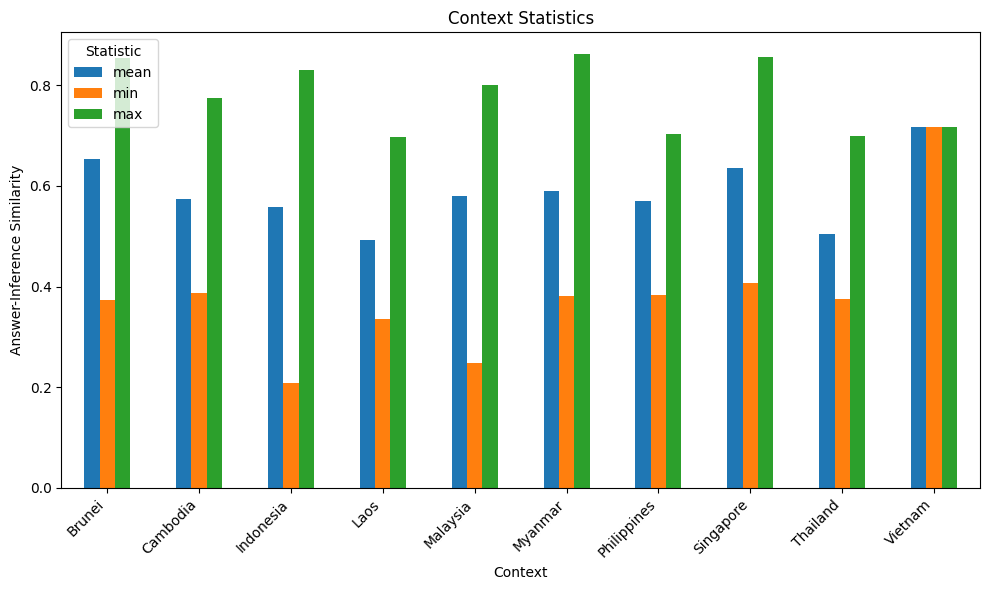

In [43]:
context_stats.plot(kind='bar', figsize=(10, 6))
plt.title('Context Statistics')
plt.xlabel('Context')
plt.ylabel('Answer-Inference Similarity')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Statistic')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()